Import relevant packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import json
import numpy as np
import random
import os

tf.enable_eager_execution()
#tf.compat.v1.set_random_seed(18)

/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

Set up data loading functions.

In [2]:
# One shot learning - Each network takes input and output and tries to compare if two tasks are the same.
Xt = []
Yt = []
Xv = []
Yv = []

rng = np.random.default_rng()

def load(name, training):
    with open(name) as json_file:
        data = json.load(json_file) 
        ctask = []
        for t in data['train']:
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cX = np.concatenate((cinr, coutr))
            ctask.append(cX)
            if training:
                Yt.append(name)
            else:
                Yv.append(name)
        if training:
            Xt.append(np.array(ctask))
        else:
            Xv.append(np.array(ctask))

def testAccuracy(model, N, loops, training):
    if training:
        X = Xt
        Y = Yt
    else:
        X = Xv
        Y = Yv
    right = 0
    wrong = 0
    for _ in range(loops):
        basecategory = random.randint(0, X.shape[0]-1)
        baseTask = X[basecategory][0].reshape(60, 30, 1)
        baseProb = model.predict([np.array([baseTask]), np.array([X[basecategory][random.randint(1, X[basecategory].shape[0]-1)].reshape(60, 30, 1)])])[0][0]
        for i in range(0, N):
            ccategory = (basecategory+random.randint(1, X.shape[0]))%X.shape[0]
            cindex = random.randint(0, X[ccategory].shape[0]-1)
            ctask = X[ccategory][cindex] 
            cProb = model.predict([np.array([baseTask]), np.array([ctask.reshape(60, 30, 1)])])
            if cProb[0][0] > baseProb:
                wrong += 1
                break
        else:
            right += 1
    return (100*right)/loops

def getBatch(batchsize, training):
    if training:
        X = Xt
        Y = Yt
    else:
        X = Xv
        Y = Yv
    categories = rng.choice(X.shape[0], size=(batchsize,), replace=False)
    targets = np.zeros((batchsize,))
    targets[batchsize//2:] = 1
    pairs=[np.zeros((batchsize, 60, 30, 1)) for i in range(2)]
    for i in range(batchsize):
        category = categories[i]
        pairs[0][i,:,:,:] = X[category][random.randint(0, X[category].shape[0]-1)].reshape(60, 30, 1)
        if i >= batchsize // 2:
            category_2 = category
        else:
            category_2 = (category + random.randint(1, X.shape[0])) % X.shape[0] 
        pairs[1][i,:,:,:] = X[category_2][random.randint(0, X[category_2].shape[0]-1)].reshape(60, 30, 1)
    return pairs, targets

def generate(batchsize, training):
    while True:
        pairs, targets = getBatch(batchsize, training)
        yield (pairs, targets)

Load data.

In [3]:
with os.scandir('training/') as entries:
    for entry in entries:
        load("training/"+entry.name, True)

with os.scandir('test/') as entries:
    for entry in entries:
        load("test/"+entry.name, False)

Xt = np.array(Xt)
Xv = np.array(Xv)
Yt = np.array(Yt)
Yv = np.array(Yv)

Define model.

In [4]:
# This function is based off the example in this tutorial: https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
def get_siamese_model(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    model = Sequential()
    model.add(Conv2D(64, (10,10), padding="same", activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), padding="same", activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), padding="same", activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), padding="same", activation='relu'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid'))

    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    return siamese_net

Train model.

In [5]:
model = get_siamese_model((60, 30, 1))
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer)
print(testAccuracy(model, 10, 18, False))

bestAccuracy = 0

for i in range(100):
    model.fit_generator(generate(128, True), epochs=1, steps_per_epoch=50)
    accuracy = testAccuracy(model, 20, 18, False)
    if accuracy > bestAccuracy:
        model.save_weights("bestCheckpoint/best")
        bestAccuracy = accuracy
        print("New Best: "+str(bestAccuracy))

11.11111111111111
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
50/50 [==============================] - 11s 226ms/step - loss: 0.5848
New Best: 22.22222222222222
50/50 [==============================] - 10s 197ms/step - loss: 0.4759
New Best: 27.77777777777778
50/50 [==============================] - 10s 198ms/step - loss: 0.3549
New Best: 44.44444444444444
33/50 [==================>...........] - ETA: 3s - loss: 0.3048

KeyboardInterrupt: 

Adversarial Generation.

In [6]:
#sampletask = [np.array([AI.Xt[0][0].reshape(60,30,1)]), np.array([AI.Xt[1][1].reshape(60,30,1)])]
loss_object = tf.keras.losses.BinaryCrossentropy()
def getGradients(taskin, cmodel):
    taskin[0] = tf.convert_to_tensor(taskin[0].astype(np.float32))
    taskin[1] = tf.convert_to_tensor(taskin[1].astype(np.float32))
    with tf.GradientTape() as tape:
        tape.watch(taskin)
        prediction = cmodel(taskin)
        loss = loss_object(tf.convert_to_tensor(np.array([1]).reshape(1, 1)), prediction)
    gradient = tape.gradient(loss, taskin)
    #signs = tf.sign(gradient)
    return [gradient[1].numpy()[0][30:], loss]

def generateTask(example, cin, l, epochs, cmodel):
    example = example.astype(np.float64)
    cin = cin.astype(np.float64)
    for i in range(epochs):
        sampletask = [np.array([example.reshape(60,30,1)]), np.array([cin.reshape(60,30,1)])] 
        result = getGradients(sampletask, cmodel)
        grads = result[0]
        grads *= l
        adjustment = np.zeros((60,30,1))
        adjustment[30:, :, :] = grads
        cin -= adjustment.reshape((60, 30))
        np.clip(cin, -1, 9, out=cin)
        if i%200 == 0:
            print("EPOCH "+str(i)+": "+str(result[1].numpy()))
    return cin.reshape(60, 30)[30:, :]

In [7]:
import matplotlib.pyplot as plt
model = get_siamese_model((60, 30, 1))
model.load_weights("bestCheckpoint/best")

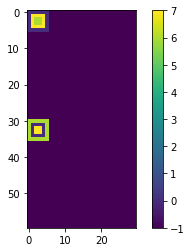

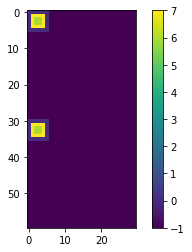

EPOCH 0: 0.3642967
EPOCH 200: 0.01863686
EPOCH 400: 0.013173666
EPOCH 600: 0.01099409
EPOCH 800: 0.00969204
EPOCH 1000: 0.008769105
EPOCH 1200: 0.008099906
EPOCH 1400: 0.007547057
EPOCH 1600: 0.007117507
EPOCH 1800: 0.0067962157


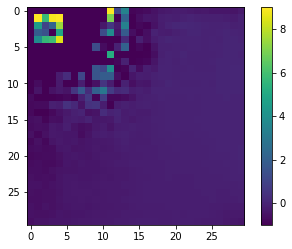

In [12]:
plt.imshow(Xt[3][1].reshape(60, 30))
plt.colorbar()
plt.show()
sampletask = [np.array([Xt[3][0].reshape(60,30,1)]), np.array([Xt[3][1].reshape(60,30,1)])]
sampletask[1][0][30:, :, :] = sampletask[1][0][:30, :, :]
#sampletask[1][0][30:, :, :] = np.random.randint(-1, 11, size=(30, 30, 1))
plt.imshow(sampletask[1].reshape(60, 30))
plt.colorbar()
plt.show()
out = generateTask(sampletask[0].reshape(60, 30), sampletask[1].reshape(60, 30), 20, 2000, model)
plt.imshow(out)
plt.colorbar()
plt.show()